In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pymysql
import getpass
import matplotlib.pyplot as plt
import statsmodels.api as sm

pd.set_option("display.max_rows", 500)
%matplotlib inline
sns.set_style("ticks")

# Black Friday Analysis

Based on our performance in 2017, should we rerun the Black Friday campaign?

### I. Getting the data

In [2]:
conn = pymysql.connect(host="localhost",
                       port=3306,
                       user="ironhack",
                       passwd=getpass.getpass(),
                       db="olist")

········


In [3]:
weekly_rev_q = """
SELECT
    DATE_SUB(DATE(order_purchase_timestamp), INTERVAL DAYOFWEEK(order_purchase_timestamp)-1 DAY) AS week_id,
    ROUND(SUM(price),2) AS revenue
FROM olist.order_items oi
    JOIN olist.orders o
    ON oi.order_id = o.order_id
WHERE o.order_status IN ('delivered', 'shipped')
    AND o.order_purchase_timestamp >= '2017-01-02'
    AND o.order_purchase_timestamp <= '2018-09-02'
GROUP BY 1
ORDER BY 1;
"""

df = pd.read_sql(weekly_rev_q, conn)

In [4]:
df.head()

,week_id,revenue
0,2017-01-01,2665.18
1,2017-01-08,9770.37
2,2017-01-15,22041.99
3,2017-01-22,52446.51
4,2017-01-29,67355.53


In [5]:
df.dtypes

week_id     object
revenue    float64
dtype: object

In [6]:
df["week_id"] = pd.to_datetime(df["week_id"])

In [7]:
type(df.set_index("week_id"))

pandas.core.frame.DataFrame

In [8]:
df = df.set_index("week_id")

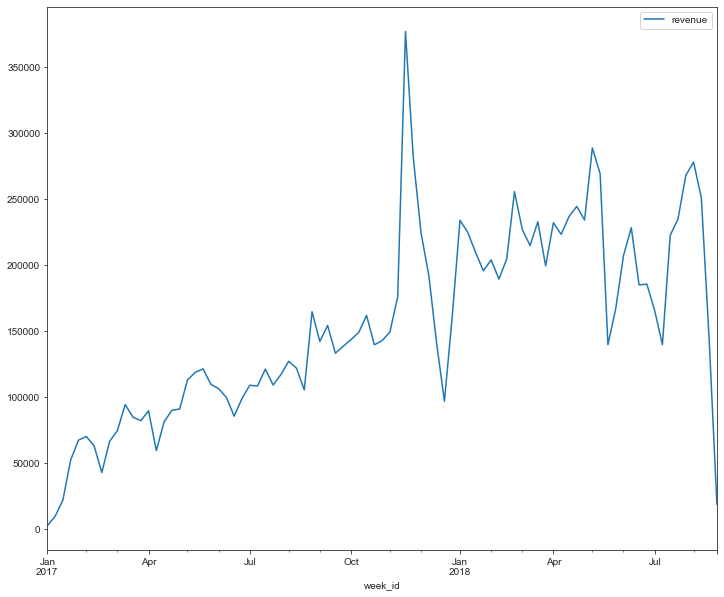

In [9]:
fig, ax = plt.subplots(figsize=(12,10))
df.plot(ax=ax);

Zoom into black friday sale

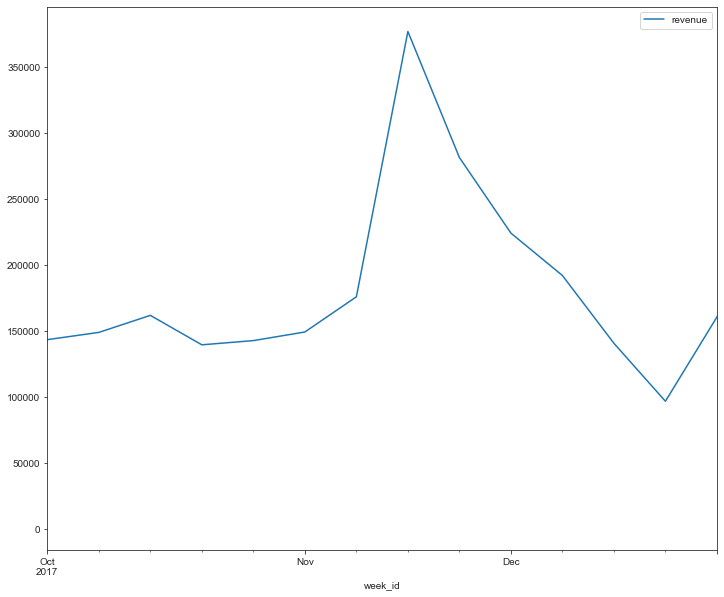

In [10]:
fig, ax = plt.subplots(figsize=(12,10))
df.plot(ax=ax);
ax.set_xlim("2017-10-01", "2017-12-31");

In [11]:
df.loc["2017-11-01":"2017-12-31"]

,revenue
week_id,
2017-11-05,149220.07
2017-11-12,175853.71
2017-11-19,376578.80
2017-11-26,281261.35
2017-12-03,224047.05
2017-12-10,191966.68
2017-12-17,140685.92
2017-12-24,96817.85
2017-12-31,160551.61


## Approach 1: 
Assume the revenue we generated in the week prior to black friday, is what we would have realized in the week of black friday, without any promotion

In [12]:
before_bf_ts = "2017-11-12"
week_of_bf_ts = "2017-11-19"

df.loc[before_bf_ts:week_of_bf_ts]

,revenue
week_id,
2017-11-12,175853.71
2017-11-19,376578.80


In [13]:
df.loc["2017-11-12","revenue"]

175853.71

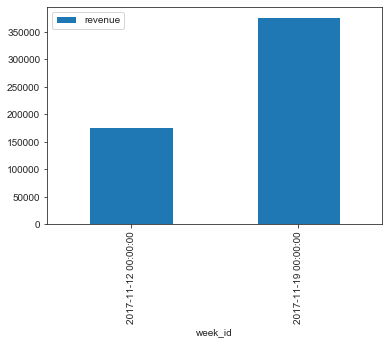

In [14]:
df.loc[before_bf_ts:week_of_bf_ts].plot(kind="bar");
# ax.axhline(color="r");

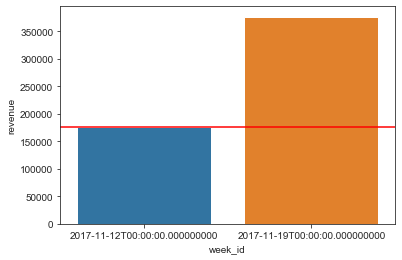

In [15]:
fig, ax = plt.subplots();
sns.barplot(data=df.loc[before_bf_ts:week_of_bf_ts],
            x=df.loc[before_bf_ts:week_of_bf_ts].index,
            y="revenue",
            ax=ax);
ax.axhline(df.loc["2017-11-12","revenue"], color="r");

Calculating difference:
- absolute
- relative

In [16]:
rev_before_bf = df.loc[before_bf_ts, "revenue"]
rev_week_of_bf = df.loc[week_of_bf_ts, "revenue"]

abs_diff = rev_week_of_bf - rev_before_bf
rel_diff = (rev_week_of_bf / rev_before_bf) - 1

print(f"""The revenue for the week of black friday increased by {int(rel_diff*100)}% compared to the week before.
Assuming the black friday promotion accounts for the entire difference, we were able to increase our revenue by {int(abs_diff)} For reals.
""")

The revenue for the week of black friday increased by 114% compared to the week before.
Assuming the black friday promotion accounts for the entire difference, we were able to increase our revenue by 200725 For reals.



## Approach 2:
Adjust for trend and preponed and postponed sales.

In the following, we want to model `revenue` as a linear function the depends on time so that we can account for a trend.

$revenue_t = c + (t_t * trend)$



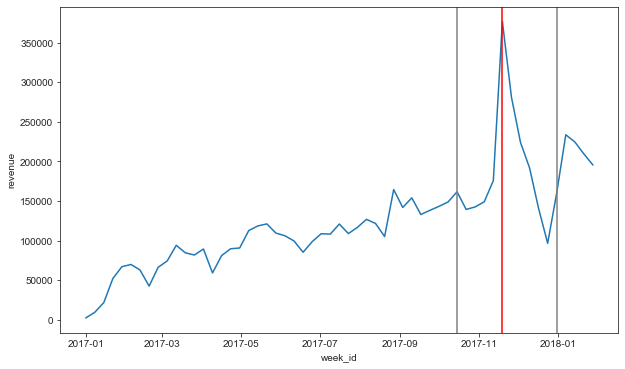

In [17]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=df.loc["2017-01-01":"2018-02-01"],
             x=df.loc["2017-01-01":"2018-02-01"].index,
             y="revenue",
             ax=ax);
ax.axvline("2017-10-15", c="grey");
ax.axvline("2017-12-31", c="grey");
ax.axvline("2017-11-19", c="red");

Prepare data to estimate a fitted line

In [18]:
df = (df.reset_index())

In [19]:
# create time variable
df = df.assign(t=df.index+1)

In [20]:
# create constant
df = df.assign(constant=1)

In [21]:
df = df.set_index("week_id")

In [22]:
# run linear regression
rev_train = df.loc["2017-01-01":"2017-10-15"]

# create variables
y = rev_train["revenue"]
X = rev_train[["constant", "t"]]
lin_reg = sm.OLS(y, X)
results = lin_reg.fit()

In [23]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     188.7
Date:                Mon, 03 Feb 2020   Prob (F-statistic):           9.87e-17
Time:                        15:04:35   Log-Likelihood:                -465.66
No. Observations:                  42   AIC:                             935.3
Df Residuals:                      40   BIC:                             938.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant    3.678e+04   5089.034      7.227      0.000    2.65e+04    4.71e+04
t           2832.2359    206.190     13.736      0.000    2415.511    3248.961
==============================================================================
Omnibus:                        0.701   Durbin-Watson:                   1.018
Prob(Omnibus):                  0.704   Jarque-Bera (JB):                0.763
Skew:                          -0.275   Prob(JB):                        0.683
Kurtosis:                       2.635   Cond. No.                         50.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
results.params

constant    36779.425482
t            2832.235935
dtype: float64

In [25]:
df_app2 = df.copy()

In [26]:
df_app2 = df_app2.assign(predicted_revenue=(results.params["constant"] + df_app2["t"] * results.params["t"]))

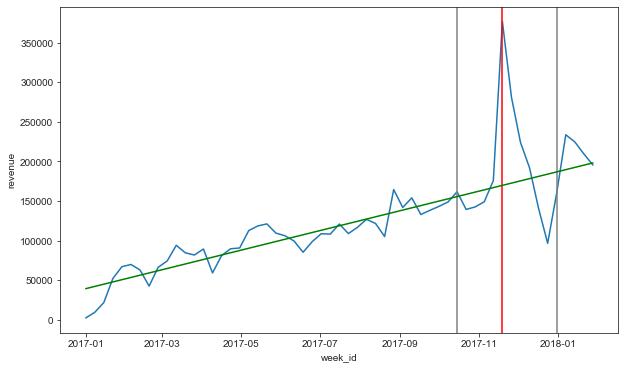

In [27]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=df_app2.loc["2017-01-01":"2018-02-01"],
             x=df_app2.loc["2017-01-01":"2018-02-01"].index,
             y="revenue",
             ax=ax);
ax.axvline("2017-10-15", c="grey");
ax.axvline("2017-12-31", c="grey");
ax.axvline("2017-11-19", c="red");
ax.plot(df_app2.loc["2017-01-01":"2018-02-01", "predicted_revenue"], color="green");

In [28]:
df_app2

,revenue,t,constant,predicted_revenue
week_id,,,,
2017-01-01,2665.18,1,1,39611.661417
2017-01-08,9770.37,2,1,42443.897353
2017-01-15,22041.99,3,1,45276.133288
2017-01-22,52446.51,4,1,48108.369224
2017-01-29,67355.53,5,1,50940.605159
2017-02-05,70120.92,6,1,53772.841095
2017-02-12,63167.79,7,1,56605.077030
2017-02-19,42889.99,8,1,59437.312966
2017-02-26,66537.45,9,1,62269.548901


In [29]:
# give you the same predicted_revenue column
results.predict(df_app2[["constant", "t"]]).head()

week_id
2017-01-01    39611.661417
2017-01-08    42443.897353
2017-01-15    45276.133288
2017-01-22    48108.369224
2017-01-29    50940.605159
dtype: float64

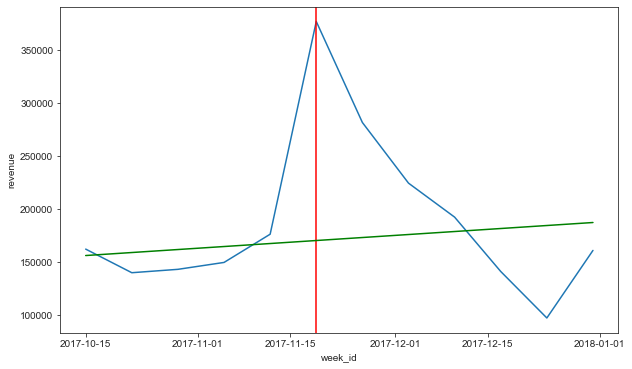

In [30]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=df_app2.loc["2017-10-15":"2017-12-31"],
             x=df_app2.loc["2017-10-15":"2017-12-31"].index,
             y="revenue",
             ax=ax);

ax.axvline("2017-11-19", c="red");
ax.plot(df_app2.loc["2017-10-15":"2017-12-31", "predicted_revenue"], color="green");

In [31]:
analysis = df_app2.loc["2017-10-15":"2017-12-31"]
analysis

,revenue,t,constant,predicted_revenue
week_id,,,,
2017-10-15,161796.27,42,1,155733.334773
2017-10-22,139524.29,43,1,158565.570708
2017-10-29,142710.87,44,1,161397.806644
2017-11-05,149220.07,45,1,164230.042579
2017-11-12,175853.71,46,1,167062.278515
2017-11-19,376578.80,47,1,169894.514450
2017-11-26,281261.35,48,1,172726.750386
2017-12-03,224047.05,49,1,175558.986321
2017-12-10,191966.68,50,1,178391.222257


In [32]:
analysis = analysis.assign(abs_diff=analysis["revenue"] - analysis["predicted_revenue"])

In [33]:
abs_diff_trend = analysis["abs_diff"].sum()
abs_diff_trend

185286.88098128195

In [34]:
rel_diff_trend = (analysis["revenue"].sum() / analysis["predicted_revenue"].sum()) - 1
rel_diff_trend

0.09013202039562374

In [38]:
df = df.drop(columns=["t", "constant"])

## Approach 3:

Fit a quadratic line. Start over again.

Steps:

- create time variable `t`
- create squared time variable
- create constant
- run OLS to find model specification
- predict baseline
- compute differences

In [49]:
# 1. create time variable
df = df.assign(t=range(1, len(df) + 1))
df.head()

,revenue,t
week_id,,
2017-01-01,2665.18,1
2017-01-08,9770.37,2
2017-01-15,22041.99,3
2017-01-22,52446.51,4
2017-01-29,67355.53,5


In [52]:
# 2. create squared time variable
df = df.assign(t2=df["t"]*df["t"])
df.head()

,revenue,t,t2
week_id,,,
2017-01-01,2665.18,1,1
2017-01-08,9770.37,2,4
2017-01-15,22041.99,3,9
2017-01-22,52446.51,4,16
2017-01-29,67355.53,5,25


In [55]:
# 3. add constant
df = sm.add_constant(df)
df.head()

,const,revenue,t,t2
week_id,,,,
2017-01-01,1.0,2665.18,1,1
2017-01-08,1.0,9770.37,2,4
2017-01-15,1.0,22041.99,3,9
2017-01-22,1.0,52446.51,4,16
2017-01-29,1.0,67355.53,5,25


In [56]:
# 4. find quadratic line using OLS
# 4.1. restrict the time period of quasi-known data
rev_q_train = df[:"2017-10-15"].copy()

y = rev_q_train["revenue"]
X = rev_q_train[["const", "t", "t2"]]

quadr_reg = sm.OLS(y, X)
results_quadr = quadr_reg.fit()
results_quadr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     103.7
Date:                Mon, 03 Feb 2020   Prob (F-statistic):           2.44e-16
Time:                        15:16:31   Log-Likelihood:                -463.56
No. Observations:                  42   AIC:                             933.1
Df Residuals:                      39   BIC:                             938.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.507e+04   7580.737      3.306      0.002    9731.793    4.04e+04
t           4429.6194    813.121      5.448      0.000    2784.926    6074.313
t2           -37.1485     18.337     -2.026      0.050     -74.238      -0.058
==============================================================================
Omnibus:                        1.907   Durbin-Watson:                   1.119
Prob(Omnibus):                  0.385   Jarque-Bera (JB):                1.226
Skew:                          -0.093   Prob(JB):                        0.542
Kurtosis:                       2.184   Cond. No.                     2.57e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.57e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [61]:
df = df.assign(predicted_rev_q=results_quadr.predict(df[["const", "t", "t2"]]))

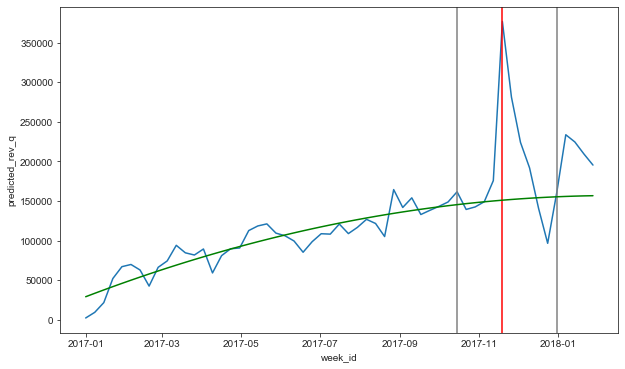

In [63]:
fig, ax = plt.subplots(figsize=(10,6))
sns.lineplot(data=df.loc["2017-01-01":"2018-02-01"],
             x=df.loc["2017-01-01":"2018-02-01"].index,
             y="revenue",
             ax=ax);
ax.axvline("2017-10-15", c="grey");
ax.axvline("2017-12-31", c="grey");
ax.axvline("2017-11-19", c="red");

sns.lineplot(data=df.loc["2017-01-01":"2018-02-01"],
             x=df.loc["2017-01-01":"2018-02-01"].index,
             y="predicted_rev_q",
             ax=ax,
             color="green");

### Lab exercise:
Rerun the previous steps and calculate the incremental revenue attributable to Black Friday, both in absolute and relative.